In [1]:
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer,MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report


df = pd.read_csv(r"heart_cleaned.csv")
df.drop(columns = ['id','dataset'],inplace = True)

In [2]:
df.drop(columns = ['thal','ca'],inplace = True)

In [3]:
X = df.drop(columns='num', axis = 1)  # or whatever your label is
y = df['num']
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 42)
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope
880,62,Male,asymptomatic,NaN,170.0,False,st-t abnormality,120.0,True,3.0,NaN
457,54,Male,non-anginal,150.0,NaN,False,normal,122.0,False,0.0,NaN
797,51,Male,non-anginal,NaN,339.0,False,normal,NaN,NaN,NaN,NaN
25,50,Female,non-anginal,120.0,219.0,False,normal,158.0,False,1.6,flat
84,52,Male,atypical angina,120.0,325.0,False,normal,172.0,False,0.2,upsloping
...,...,...,...,...,...,...,...,...,...,...,...
106,59,Male,asymptomatic,140.0,177.0,False,normal,162.0,True,0.0,upsloping
270,61,Male,asymptomatic,140.0,207.0,False,lv hypertrophy,138.0,True,1.9,upsloping
860,75,Male,asymptomatic,160.0,310.0,True,normal,112.0,True,2.0,downsloping
435,53,Female,atypical angina,140.0,216.0,False,normal,142.0,True,2.0,flat


In [4]:
si = SimpleImputer(strategy = 'most_frequent')
X_train[['restecg' ,'exang','fbs','slope']] = si.fit_transform(X_train[['restecg' ,'exang','fbs','slope']])
X_test[['restecg' ,'exang','fbs','slope']] = si.transform(X_test[['restecg' ,'exang','fbs','slope']])

In [5]:
scale_columns = ['age','trestbps', 'chol' ,'thalch', 'oldpeak']
ss = StandardScaler()
X_train[scale_columns]  = ss.fit_transform(X_train[scale_columns])
X_test[scale_columns]  = ss.transform(X_test[scale_columns])
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope
880,0.902413,Male,asymptomatic,NaN,-1.360203,False,st-t abnormality,-0.676174,True,1.989372,flat
457,0.034776,Male,non-anginal,0.976363,NaN,False,normal,-0.598702,False,-0.828147,flat
797,-0.290587,Male,non-anginal,NaN,1.697387,False,normal,NaN,False,NaN,flat
25,-0.399042,Female,non-anginal,-0.639847,-0.473683,False,normal,0.795789,False,0.674530,flat
84,-0.182133,Male,atypical angina,-0.639847,1.444096,False,normal,1.338091,False,-0.640312,upsloping
...,...,...,...,...,...,...,...,...,...,...,...
106,0.577049,Male,asymptomatic,0.437626,-1.233557,False,normal,0.950732,True,-0.828147,upsloping
270,0.793958,Male,asymptomatic,0.437626,-0.690790,False,lv hypertrophy,0.021071,True,0.956282,upsloping
860,2.312322,Male,asymptomatic,1.515099,1.172712,True,normal,-0.986061,True,1.050199,downsloping
435,-0.073678,Female,atypical angina,0.437626,-0.527959,False,normal,0.176015,True,1.050199,flat


In [6]:
cp_order =  [['typical angina', 'atypical angina', 'non-anginal', 'asymptomatic']]
slope_order = [['upsloping', 'flat', 'downsloping']]
thal_order =  [['normal', 'fixed defect', 'reversable defect']]
restecg_order =  [['normal','st-t abnormality','lv hypertrophy']]

#Ordinal Encoder 
ordinal_cp = OrdinalEncoder(categories=cp_order, handle_unknown='use_encoded_value',unknown_value = np.nan , dtype=float)
ordinal_slope = OrdinalEncoder(categories=slope_order, handle_unknown='use_encoded_value', unknown_value = np.nan, dtype=float)
ordinal_restecg = OrdinalEncoder(categories= restecg_order,handle_unknown='use_encoded_value',unknown_value = np.nan, dtype=float)

def map_custom_categories(X):
    X = X.copy()
    
    sex_mapping = {'Female': 0 ,'Male': 1}
    
    exang_mapping = {False: 0,True: 1}

    fbs_mapping = {False: 0,True: 1}   


    X['sex'] = X['sex'].map(sex_mapping)
    X['exang'] = X['exang'].map(exang_mapping)
    X['fbs'] = X['fbs'].map(fbs_mapping)
 
    return X

binary_mapping = FunctionTransformer(map_custom_categories)

restecg_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),("encoding", ordinal_restecg)])
cp_encode = ordinal_cp
slope_encode = ordinal_slope


encoding_cat = ColumnTransformer(transformers=[
    ('restecg_pipeline', restecg_pipeline,['restecg']),
    ('binary_encoding',binary_mapping, ['sex','exang','fbs']),
    ('cp_encoding', cp_encode, ['cp']),
    ('slope_encoding',slope_encode, ['slope']),
 ], remainder='passthrough',verbose_feature_names_out = False)



encoding_cat.set_output(transform='pandas')

X_train_transformed = encoding_cat.fit_transform(X_train)
X_test_transformed = encoding_cat.transform(X_test)

In [7]:
order = X_train.columns
X_train_encoded = X_train_transformed[order]
X_test_encoded = X_test_transformed[order]

In [8]:
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.set_output(transform = 'pandas')
knn_features = [ 'trestbps', 'thalch', 'oldpeak'] #'age', 'restecg', 'trestbps', 'thalch', 'oldpeak', 'exang'
impute_targets = ['trestbps', 'thalch', 'oldpeak']

# 3a. Fit on train, transform both train and test
X_train_knn = X_train_encoded[knn_features].copy()
X_test_knn = X_test_encoded[knn_features].copy()

X_train_knn_imputed = knn_imputer.fit_transform(X_train_knn)
                                

X_test_knn_imputed = knn_imputer.transform(X_test_knn)

# Replace imputed targets in original train/test sets
X_train_encoded[impute_targets] = X_train_knn_imputed[impute_targets]
X_test_encoded[impute_targets] = X_test_knn_imputed[impute_targets]





In [9]:
# Select columns for imputation
features_for_chol = ['chol','age' , 'sex' , 'fbs', 'thalch', 'age','cp','restecg']

X_train_chol = X_train_encoded[features_for_chol].copy()
X_test_chol = X_test_encoded[features_for_chol].copy()

chol_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                                max_iter=10,
                                random_state=0)

# Fit on training data
X_train_chol_imputed = chol_imputer.fit_transform(X_train_chol)

# Transform test data using the same fitted imputer
X_test_chol_imputed = chol_imputer.transform(X_test_chol)

# Replace only 'chol' in X_train_transformed and X_test_transformed
X_train_encoded.loc[:, 'chol'] = X_train_chol_imputed[:, 0]
X_test_encoded.loc[:, 'chol'] = X_test_chol_imputed[:, 0]



# Decision Tree

In [10]:

X_train_transformed = X_train_encoded 
X_test_transformed  = X_test_encoded 

In [11]:
X_train_transformed

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope
880,0.902413,1,3.0,1.359334e-01,-1.360203,0,1.0,-6.761741e-01,1,1.989372e+00,1.0
457,0.034776,1,2.0,9.763627e-01,-0.115682,0,0.0,-5.987024e-01,0,-8.281465e-01,1.0
797,-0.290587,1,2.0,-3.629947e-16,1.697387,0,0.0,-8.357068e-16,0,2.300781e-16,1.0
25,-0.399042,0,2.0,-6.398475e-01,-0.473683,0,0.0,7.957887e-01,0,6.745299e-01,1.0
84,-0.182133,1,1.0,-6.398475e-01,1.444096,0,0.0,1.338091e+00,0,-6.403120e-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...
106,0.577049,1,3.0,4.376260e-01,-1.233557,0,0.0,9.507321e-01,1,-8.281465e-01,0.0
270,0.793958,1,3.0,4.376260e-01,-0.690790,0,2.0,2.107142e-02,1,9.562818e-01,0.0
860,2.312322,1,3.0,1.515099e+00,1.172712,1,0.0,-9.860610e-01,1,1.050199e+00,2.0
435,-0.073678,0,1.0,4.376260e-01,-0.527959,0,0.0,1.760149e-01,1,1.050199e+00,1.0


In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
model = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = 42)
score = cross_val_score(model ,X_train_transformed , y_train , cv = cv , scoring = "accuracy")
print(score)
print(np.mean(score))

model.fit(X_train_transformed,y_train)
print(model.score(X_test_transformed,y_test))

[0.65540541 0.6462585  0.76190476 0.63945578 0.67346939]
0.675298768155911
0.6847826086956522


In [14]:
model = DecisionTreeClassifier(min_samples_leaf = 3 , min_impurity_decrease = 0.00001,max_leaf_nodes = 20 )
cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = 42)
score = cross_val_score(model ,X_train_transformed , y_train , cv = cv , scoring = "accuracy")
print(score)
print(np.mean(score))

[0.71621622 0.70748299 0.81632653 0.70748299 0.75510204]
0.7405221548078691


In [15]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
from optuna.samplers import TPESampler

def objective(trial):
    # Allow 'None' as an option for parameters
    max_depth = trial.suggest_categorical("max_depth", [None] + list(range(2, 20)))
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_leaf_nodes = trial.suggest_categorical("max_leaf_nodes", [None] + list(range(5, 50)))
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 1e-7, 1e-2, log=True)

    
    # Create the model with suggested hyperparameters
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        random_state=42
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='accuracy')

    return np.mean(score)

# Start the study
study = optuna.create_study(direction="maximize" , sampler = TPESampler(seed=42) )
study.optimize(objective, n_trials=50)

# Print results
print("Best mean CV accuracy:", study.best_value)
print("Best parameters:", study.best_params)


[I 2025-09-06 12:32:59,497] A new study created in memory with name: no-name-58e2a89f-940c-4244-846b-632e9f0bdde3
[I 2025-09-06 12:32:59,582] Trial 0 finished with value: 0.7160599374885089 and parameters: {'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_leaf_nodes': 33, 'min_impurity_decrease': 0.001025616274847309}. Best is trial 0 with value: 0.7160599374885089.
[I 2025-09-06 12:32:59,642] Trial 1 finished with value: 0.7609578966721824 and parameters: {'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_leaf_nodes': 49, 'min_impurity_decrease': 4.130614451133167e-06}. Best is trial 1 with value: 0.7609578966721824.
[I 2025-09-06 12:32:59,706] Trial 2 finished with value: 0.7187626401912116 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_leaf_nodes': 25, 'min_impurity_decrease': 0.0031100755757274947}. Best is trial 1 with value: 0.7609578966721824.
[I 2025-09-06 12:32:59,785] Trial 3 finished with value:

Best mean CV accuracy: 0.7677238462952749
Best parameters: {'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_leaf_nodes': 39, 'min_impurity_decrease': 0.0006509902752228316}


In [16]:
# ✅ Best mean CV accuracy: 0.7636330207758779
# 🧠 Best parameters: {'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 18, 'max_leaf_nodes': 34, 'min_impurity_decrease': 0.00018525474790326396}

In [17]:
model_tuned = DecisionTreeClassifier(**study.best_params)
cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = 42)
score = cross_val_score(model_tuned ,X_train_transformed , y_train , cv = cv , scoring = "accuracy")
print(score)
print(np.mean(score))

[0.72297297 0.78911565 0.78911565 0.72789116 0.80952381]
0.7677238462952749



🎯 Test Accuracy (using tuned threshold): 0.7880

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        75
           1       0.85      0.78      0.81       109

    accuracy                           0.79       184
   macro avg       0.78      0.79      0.78       184
weighted avg       0.79      0.79      0.79       184



C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


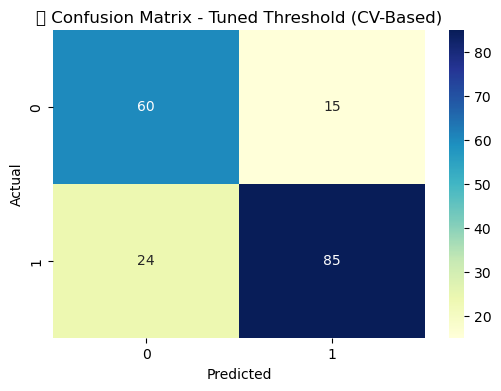

In [18]:
model_tuned.fit(X_train_transformed , y_train)
y_pred = model_tuned.predict(X_test_transformed)


cm_best = confusion_matrix(y_test, y_pred)
acc_best = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy (using tuned threshold): {acc_best:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlGnBu')
plt.title(" Confusion Matrix - Tuned Threshold (CV-Based)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
import graphviz.backend as be
from dtreeviz import *
from IPython.display import Image , display_svg , SVG

In [20]:
from sklearn.tree import plot_tree

[Text(0.5375, 0.9, 'x[2] <= 2.5\ngini = 0.496\nsamples = 736\nvalue = [336, 400]'),
 Text(0.325, 0.7, 'x[9] <= 1.003\ngini = 0.395\nsamples = 339\nvalue = [247.0, 92.0]'),
 Text(0.43125, 0.8, 'True  '),
 Text(0.2, 0.5, 'x[7] <= 0.011\ngini = 0.348\nsamples = 303\nvalue = [235.0, 68.0]'),
 Text(0.1, 0.3, 'x[1] <= 0.5\ngini = 0.474\nsamples = 106\nvalue = [65, 41]'),
 Text(0.05, 0.1, 'gini = 0.153\nsamples = 24\nvalue = [22, 2]'),
 Text(0.15, 0.1, 'gini = 0.499\nsamples = 82\nvalue = [43, 39]'),
 Text(0.3, 0.3, 'x[0] <= -0.779\ngini = 0.237\nsamples = 197\nvalue = [170, 27]'),
 Text(0.25, 0.1, 'gini = 0.051\nsamples = 77\nvalue = [75, 2]'),
 Text(0.35, 0.1, 'gini = 0.33\nsamples = 120\nvalue = [95, 25]'),
 Text(0.45, 0.5, 'x[7] <= 0.253\ngini = 0.444\nsamples = 36\nvalue = [12, 24]'),
 Text(0.4, 0.3, 'gini = 0.291\nsamples = 17\nvalue = [3, 14]'),
 Text(0.5, 0.3, 'gini = 0.499\nsamples = 19\nvalue = [9, 10]'),
 Text(0.75, 0.7, 'x[9] <= -0.218\ngini = 0.348\nsamples = 397\nvalue = [89, 30

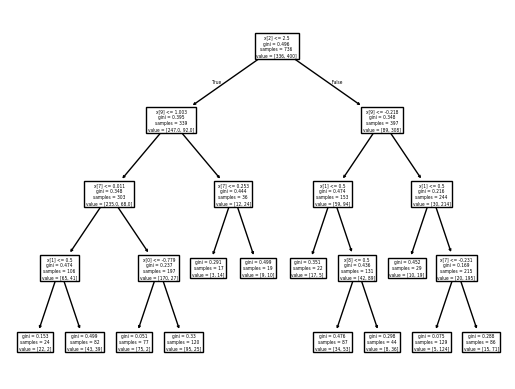

In [21]:
plot_tree(model_tuned)